In this notebook we tried to compare 4 different classification models (KNN, Decision Tree, SVM, Logistic Regression) and find the most accurate one.

Here we have two .csv files which are **train_data** and **test_data** correspondingly.

Therefore, we will fit (train) and predict (test) the data separately.

# 1.) Train Data

## Import the Train Data

In [1]:
import pandas as pd
import numpy as np
import itertools

train_df = pd.read_csv("loan_train.csv")
train_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


### About the Dataset

Here is the explanation for each column in the .csv file.

| Column | Description |
| :--- | :--- | 
| Loan_status | Whether a loan is paid off or in collection |
| Principal | Basic principal loan amount at the |
| Terms | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects |
| Due_date | Since it’s one-time payoff schedule, each loan has one single due date |
| Age | Age of applicant |
| Education | Education of applicant |
| Gender | The gender of applicant |

- We need to predict the **Loan_status** - target variable (y) using the remaining explanatory variable (X).
- Each row correspond to every customer.

# Explore, Clean and Transform the Data

## Feature selection & Extraction

In [2]:
train_df.isnull().sum()

# Good we have no null value

Unnamed: 0        0
Unnamed: 0.1      0
loan_status       0
Principal         0
terms             0
effective_date    0
due_date          0
age               0
education         0
Gender            0
dtype: int64

In [3]:
train_df.shape 
# Train data has 346 Customers

(346, 10)

### > We will inspect each variable type to determine which one requires to be transformed later

In [4]:
train_df.dtypes

Unnamed: 0         int64
Unnamed: 0.1       int64
loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

__(1) Principal__

In [5]:
train_df['Principal'].value_counts()

1000    258
800      81
300       3
500       2
900       2
Name: Principal, dtype: int64

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# lets plot the loan_status between male and female with "principal" as the parameter
bins = np.linspace(train_df.Principal.min(), train_df.Principal.max(), 10)
g = sns.FacetGrid(train_df, col="Gender", hue="loan_status", palette="Set2", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

<Figure size 600x300 with 2 Axes>

- **Principal** is pretty vary and the format is in numeric so we can just normalize it later

__(2) terms__

In [7]:
train_df['terms'].value_counts()

30    184
15    148
7      14
Name: terms, dtype: int64

- **terms** here is already in numeric format, however actually it is categorical variable. So it is better to convert to **One-hot Encoding** using the **get_dummies** from pandas library.

__(3) age__

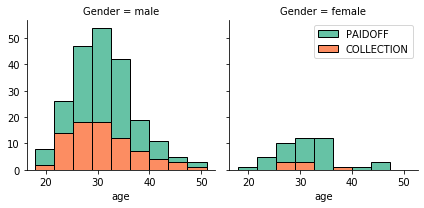

In [8]:
# It is better to plot age instead of show the value_counts because more informative and visually better.
bins = np.linspace(train_df.age.min(), train_df.age.max(), 10)
g = sns.FacetGrid(train_df, col="Gender", hue="loan_status", palette="Set2", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

- **age** is obviously a numerical data, and it is continuous except we classify it into group of interval. However, we can just normalize it later.

__(4) Date__

From .dtypes we can see if the **effective_date** and **due_date** are not in date_time format. So we need convert it first **to_datetime**.

In [9]:
train_df['effective_date'] = pd.to_datetime(train_df['effective_date'])
train_df['due_date'] = pd.to_datetime(train_df['due_date'])
train_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


Let's convert it to **.dayofweek** where the value will be between 0 (monday) and 6 (sunday). Then we plot it to see how we can format or split the day data later.

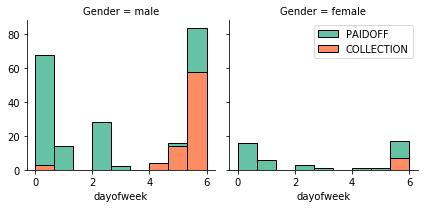

In [10]:
train_df['dayofweek'] = train_df['effective_date'].dt.dayofweek
bins = np.linspace(train_df.dayofweek.min(), train_df.dayofweek.max(), 10)
g = sns.FacetGrid(train_df, col="Gender", hue="loan_status", palette="Set2", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

- **dayofweek** shows that customer mostly got the loan between monday(0) and sunday(6).
- Sunday is the day where mostly they don't paid it off. Start from Friday to Sunday the loan that not paid increases can due to it is weekend.
- Apparently, we can split it into two different cluster which is days <4 (weekdays) and days >=4 (weekend) later. This is based on the loan payoff.

__(5) education__

In [11]:
train_df.groupby(['education'])['loan_status'].value_counts()

education             loan_status
Bechalor              PAIDOFF         33
                      COLLECTION      11
High School or Below  PAIDOFF        112
                      COLLECTION      39
Master or Above       COLLECTION       1
                      PAIDOFF          1
college               PAIDOFF        114
                      COLLECTION      35
Name: loan_status, dtype: int64

- **education** is definitely a categorical data. We can use **One Hot Encoding** method here as it is not an ordinal data. 

__(6) Gender__

In [12]:
train_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

- **Gender** is pretty obvious. As there are only 2 gender in the dataset 'male' & 'female'.

### > Formating - Extraction

In [13]:
# Let's see out train_df first!|

train_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4


In [14]:
# Create binary value for the vairable dayofweek
train_df['weekend'] = train_df['dayofweek'].apply(lambda x: 1 if x>3 else 0)
train_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


In [15]:
# here we try to extract the important column and remove unrelated for our modelling.
extract_df = train_df[['loan_status', 'Principal', 'age', 'Gender', 'weekend']]
extract_df.head()

,loan_status,Principal,age,Gender,weekend
0,PAIDOFF,1000,45,male,0
1,PAIDOFF,1000,33,female,0
2,PAIDOFF,1000,27,male,0
3,PAIDOFF,1000,28,female,1
4,PAIDOFF,1000,29,male,1


> __Convert the "education" column into One Hot Encoding and concat with extract_df__ 

In [16]:
extract_df = pd.concat([extract_df, pd.get_dummies(train_df['education'])], axis=1)
extract_df

,loan_status,Principal,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,PAIDOFF,1000,45,male,0,0,1,0,0
1,PAIDOFF,1000,33,female,0,1,0,0,0
2,PAIDOFF,1000,27,male,0,0,0,0,1
3,PAIDOFF,1000,28,female,1,0,0,0,1
4,PAIDOFF,1000,29,male,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
341,COLLECTION,800,32,male,1,0,1,0,0
342,COLLECTION,1000,25,male,1,0,1,0,0
343,COLLECTION,800,39,male,0,0,0,0,1
344,COLLECTION,1000,28,male,0,0,0,0,1


> __Convert the "terms" column into One Hot Encoding and concat with extract_df__

In [17]:
train_df['terms'].replace(to_replace =[7, 15, 30], value =['1 week', '2 weeks', '1 month'], inplace = True)
extract_df = pd.concat([extract_df, pd.get_dummies(train_df['terms'])], axis=1)
extract_df.head()

,loan_status,Principal,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college,1 month,1 week,2 weeks
0,PAIDOFF,1000,45,male,0,0,1,0,0,1,0,0
1,PAIDOFF,1000,33,female,0,1,0,0,0,1,0,0
2,PAIDOFF,1000,27,male,0,0,0,0,1,0,0,1
3,PAIDOFF,1000,28,female,1,0,0,0,1,1,0,0
4,PAIDOFF,1000,29,male,1,0,0,0,1,1,0,0


> __Convert the "Gender" column into Binary value__

In [18]:
extract_df['Gender'].replace(to_replace =['male', 'female'], value =[1, 0], inplace = True)
extract_df.head()

,loan_status,Principal,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college,1 month,1 week,2 weeks
0,PAIDOFF,1000,45,1,0,0,1,0,0,1,0,0
1,PAIDOFF,1000,33,0,0,1,0,0,0,1,0,0
2,PAIDOFF,1000,27,1,0,0,0,0,1,0,0,1
3,PAIDOFF,1000,28,0,1,0,0,0,1,1,0,0
4,PAIDOFF,1000,29,1,1,0,0,0,1,1,0,0


### > Feature selection

In [19]:
# Set data X
X1 = extract_df[['Principal', 'age', 'Gender', 'weekend', 'Bechalor', 'High School or Below', 'Master or Above', 'college',
               '1 month', '1 week', '2 weeks']].values
X1[0:5]

array([[1000,   45,    1,    0,    0,    1,    0,    0,    1,    0,    0],
       [1000,   33,    0,    0,    1,    0,    0,    0,    1,    0,    0],
       [1000,   27,    1,    0,    0,    0,    0,    1,    0,    0,    1],
       [1000,   28,    0,    1,    0,    0,    0,    1,    1,    0,    0],
       [1000,   29,    1,    1,    0,    0,    0,    1,    1,    0,    0]],
      dtype=int64)

In [20]:
# Set data y
y1= extract_df['loan_status'].values
y1[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [21]:
from sklearn import preprocessing

# Standardize the input X, as variable "age" and "Principal" need to be normalize with the remaining variables.
X1= preprocessing.StandardScaler().fit_transform(X1)
X1[0:5]

array([[ 0.51578458,  2.33152555,  0.42056004, -1.20577805, -0.38170062,
         1.13639374, -0.07624929, -0.86968108,  0.93831486, -0.20535013,
        -0.86456622],
       [ 0.51578458,  0.34170148, -2.37778177, -1.20577805,  2.61985426,
        -0.87997669, -0.07624929, -0.86968108,  0.93831486, -0.20535013,
        -0.86456622],
       [ 0.51578458, -0.65321055,  0.42056004, -1.20577805, -0.38170062,
        -0.87997669, -0.07624929,  1.14984679, -1.06574034, -0.20535013,
         1.1566494 ],
       [ 0.51578458, -0.48739188, -2.37778177,  0.82934003, -0.38170062,
        -0.87997669, -0.07624929,  1.14984679,  0.93831486, -0.20535013,
        -0.86456622],
       [ 0.51578458, -0.3215732 ,  0.42056004,  0.82934003, -0.38170062,
        -0.87997669, -0.07624929,  1.14984679,  0.93831486, -0.20535013,
        -0.86456622]])

# 2.) Test Data

Like Train Data, we do similar transform, extract and feature selection to the test data

In [22]:
test_df = pd.read_csv("loan_test.csv")
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [23]:
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if x>3 else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [24]:
extract2_df = test_df[['loan_status', 'Principal', 'age', 'Gender', 'weekend']]
extract2_df = pd.concat([extract2_df, pd.get_dummies(test_df['education'])], axis=1)

test_df['terms'].replace(to_replace =[7, 15, 30], value =['1 week', '2 weeks', '1 month'], inplace = True)
extract2_df = pd.concat([extract2_df, pd.get_dummies(test_df['terms'])], axis=1)

extract2_df['Gender'].replace(to_replace =['male', 'female'], value =[1, 0], inplace = True)

extract2_df.head()

,loan_status,Principal,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college,1 month,1 week,2 weeks
0,PAIDOFF,1000,50,0,0,1,0,0,0,1,0,0
1,PAIDOFF,300,35,1,1,0,0,1,0,0,1,0
2,PAIDOFF,1000,43,0,1,0,1,0,0,1,0,0
3,PAIDOFF,1000,26,1,1,0,0,0,1,1,0,0
4,PAIDOFF,800,29,1,1,1,0,0,0,0,0,1


In [25]:
# Set data X
X2 = extract2_df[['Principal', 'age', 'Gender', 'weekend', 'Bechalor', 'High School or Below', 'Master or Above', 'college',
               '1 month', '1 week', '2 weeks']].values
X2[0:5]

array([[1000,   50,    0,    0,    1,    0,    0,    0,    1,    0,    0],
       [ 300,   35,    1,    1,    0,    0,    1,    0,    0,    1,    0],
       [1000,   43,    0,    1,    0,    1,    0,    0,    1,    0,    0],
       [1000,   26,    1,    1,    0,    0,    0,    1,    1,    0,    0],
       [ 800,   29,    1,    1,    1,    0,    0,    0,    0,    0,    1]],
      dtype=int64)

In [26]:
# Set data y
y2= extract2_df['loan_status'].values
y2[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [27]:
# Standardize the input X, as variable "age" and "Principal" need to be normalize with the remaining variables.
X2= preprocessing.StandardScaler().fit_transform(X2)
X2[0:5]

array([[ 0.49362588,  3.05981865, -1.97714211, -1.30384048,  2.39791576,
        -0.79772404, -0.19611614, -0.86135677,  0.96362411, -0.35355339,
        -0.76696499],
       [-3.56269116,  0.53336288,  0.50578054,  0.76696499, -0.41702883,
        -0.79772404,  5.09901951, -0.86135677, -1.03774904,  2.82842712,
        -0.76696499],
       [ 0.49362588,  1.88080596, -1.97714211,  0.76696499, -0.41702883,
         1.25356634, -0.19611614, -0.86135677,  0.96362411, -0.35355339,
        -0.76696499],
       [ 0.49362588, -0.98251057,  0.50578054,  0.76696499, -0.41702883,
        -0.79772404, -0.19611614,  1.16095912,  0.96362411, -0.35355339,
        -0.76696499],
       [-0.66532184, -0.47721942,  0.50578054,  0.76696499,  2.39791576,
        -0.79772404, -0.19611614, -0.86135677, -1.03774904, -0.35355339,
         1.30384048]])

# 3.) Classification

- K Nearest Neighbors (KNN)
- Decision Tree
- Support Vector Machine
- Logistic regression

## K Nearest Neighbors (KNN)

Before we go through the model, we should find the best k for this model using the X1, y1 (Training data) since we want to find the most accurate model. So find the best k is required.

In [28]:
# Check our data first
nl = "\n"
print(f"X1 is {nl} {X1[0:5]} {nl}{nl}y1 is {nl} {y1[0:5]} {nl}{nl}")
print(f"X2 is {nl} {X2[0:5]} {nl}{nl}y2 is {nl} {y2[0:5]}")

X1 is 
 [[ 0.51578458  2.33152555  0.42056004 -1.20577805 -0.38170062  1.13639374
  -0.07624929 -0.86968108  0.93831486 -0.20535013 -0.86456622]
 [ 0.51578458  0.34170148 -2.37778177 -1.20577805  2.61985426 -0.87997669
  -0.07624929 -0.86968108  0.93831486 -0.20535013 -0.86456622]
 [ 0.51578458 -0.65321055  0.42056004 -1.20577805 -0.38170062 -0.87997669
  -0.07624929  1.14984679 -1.06574034 -0.20535013  1.1566494 ]
 [ 0.51578458 -0.48739188 -2.37778177  0.82934003 -0.38170062 -0.87997669
  -0.07624929  1.14984679  0.93831486 -0.20535013 -0.86456622]
 [ 0.51578458 -0.3215732   0.42056004  0.82934003 -0.38170062 -0.87997669
  -0.07624929  1.14984679  0.93831486 -0.20535013 -0.86456622]] 

y1 is 
 ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'] 


X2 is 
 [[ 0.49362588  3.05981865 -1.97714211 -1.30384048  2.39791576 -0.79772404
  -0.19611614 -0.86135677  0.96362411 -0.35355339 -0.76696499]
 [-3.56269116  0.53336288  0.50578054  0.76696499 -0.41702883 -0.79772404
   5.09901951 -0.86135

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

def sumOfDiagonal(matrix):
    sum = 0
    for i in range(len(matrix)):
        sum += matrix[i][i]        
    return sum

# Here we try to loop over k=(1,10) and random_state=(1,3)
score_df = pd.DataFrame()
std_arr = []

for n_state in range(1,4):
    X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state = n_state)

    store_acc = np.zeros((10))
    std_acc = np.zeros((10))
    tot_cfm = []

    for n in range(1,11):
        model = KNeighborsClassifier(n_neighbors = n)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        store_acc[n-1] = accuracy_score(y_test, y_pred)
        std_acc = np.std(y_pred==y_test)/np.sqrt(len(y_pred))
        cfm = confusion_matrix(y_test, y_pred)
        corr_pred = sumOfDiagonal(cfm)
        tot_cfm.append(corr_pred)
    store_acc
    score_df[n_state-1] = store_acc
    std_arr.append(std_acc) 


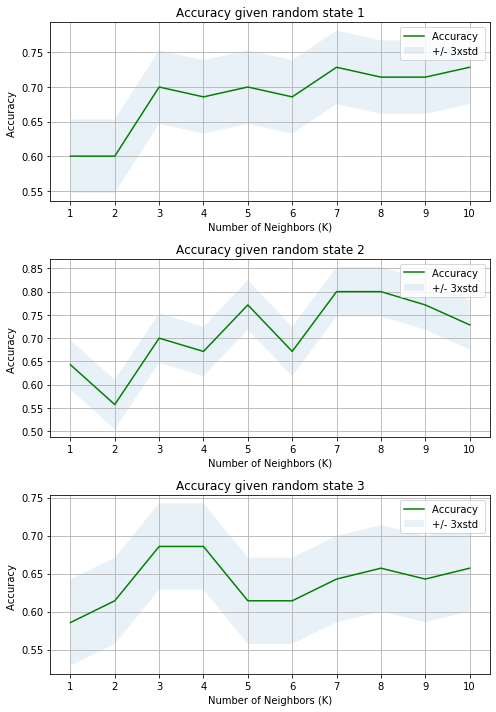

In [30]:
nl = '\n'
fig, ax = plt.subplots(3,1, figsize=(7, 10), edgecolor='k')
for i in range(0,3):
    ax[i].plot(range(1,11),score_df[i],'g')
    ax[i].fill_between(range(1,11),score_df[i] - 1 * std_arr[i] ,score_df[i] + 1 * std_arr[i], alpha=0.10)
    ax[i].xaxis.set_ticks(np.arange(1,11,1))
    ax[i].set_title(f'Accuracy given random state {i+1}')
    ax[i].legend(('Accuracy ', '+/- 3xstd'))
    ax[i].set_ylabel('Accuracy ')
    ax[i].set_xlabel('Number of Neighbors (K)')
    fig.tight_layout()
    ax[i].grid()
plt.show()

In [31]:
final = pd.DataFrame()
final['K_neighbors'] = range(1,11)
final['Accuracy n = 1'] = np.round(score_df[0],3)
final['Accuracy n = 2'] = np.round(score_df[1],3)
final['Accuracy n = 3'] = np.round(score_df[2],3)
final.set_index('K_neighbors', inplace=True)
final

,Accuracy n = 1,Accuracy n = 2,Accuracy n = 3
K_neighbors,,,
1,0.600,0.643,0.586
2,0.600,0.557,0.614
3,0.700,0.700,0.686
4,0.686,0.671,0.686
5,0.700,0.771,0.614
6,0.686,0.671,0.614
7,0.729,0.800,0.643
8,0.714,0.800,0.657
9,0.714,0.771,0.643


Here we can see that __the highest accuracy is 0.8__ when __n=2, k= 7 or 8__. Here we choose k=7.

Next, using X1 & y1 (train)  we can fit it for k=7 and predict the model with X2 & y2 (test).

In [32]:
from sklearn.metrics import f1_score
import statistics

model_KNN = KNeighborsClassifier(n_neighbors = 7)
model_KNN.fit(X1, y1)
KNN_pred = model_KNN.predict(X2)
acc1 = accuracy_score(y2, KNN_pred)
#jac1 = jaccard_similarity_score(y2, KNN_pred)
stat1 = statistics.mean(f1_score(y2, KNN_pred,average=None))

print(f"The Accuracy score: {acc1} {nl}F1 Score: {stat1}")

The Accuracy score: 0.7037037037037037 
F1 Score: 0.5090909090909091


## Decision Tree

One reason we use decision tree instead of random forest is because our dataset is not big enough, fitting small data with random forest can result in overfitting and underfitting sometimes. So Decision tree is preferable in this case. I also stated the project that show small data will yield worse accuracy by fitting random forest model. [Drug Analysis](https://github.com/nico2997/Jupyter_notebook_data_analyst/blob/main/Drugs%20analysis/Drug%20analysis.ipynb)

In [33]:
from sklearn.tree import DecisionTreeClassifier

# We try with different max depth and find the best
score2_df = pd.DataFrame()

for n_state in range(1,5): #loop n_state 4 times
    X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state = n_state)

    store_acc = np.zeros((8))
    
    for depth in range(1,9): #Loop max_depth 1 to 8
        model= DecisionTreeClassifier(criterion="entropy", max_depth = depth)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        store_acc[depth-1] = accuracy_score(y_test, y_pred)
        cfm = confusion_matrix(y_test, y_pred)
        corr_pred = sumOfDiagonal(cfm)
    store_acc
    score2_df[n_state-1] = store_acc

In [34]:
final = pd.DataFrame()
final['Max_Depth'] = range(1,9)
final['Accuracy n = 1'] = np.round(score2_df[0],4)
final['Accuracy n = 2'] = np.round(score2_df[1],4)
final['Accuracy n = 3'] = np.round(score2_df[2],4)
final['Accuracy n = 4'] = np.round(score2_df[3],4)
final.set_index('Max_Depth', inplace=True)
final

,Accuracy n = 1,Accuracy n = 2,Accuracy n = 3,Accuracy n = 4
Max_Depth,,,,
1,0.7429,0.8286,0.6714,0.7857
2,0.7429,0.8286,0.6714,0.7857
3,0.7429,0.8000,0.6714,0.6143
4,0.7429,0.7000,0.5857,0.6143
5,0.7429,0.6429,0.6143,0.6429
6,0.7429,0.6714,0.5571,0.7714
7,0.7286,0.7000,0.5714,0.7571
8,0.7286,0.7000,0.5857,0.7571


Here we can see that __the highest accuracy is 0.8286__ when __n=2, max_depth = 1 or 2__. Here we choose max_depth=2.

Next, using X1 & y1 (train)  we can fit it for max_depth=2 and predict the model with X2 & y2 (test).

In [35]:
from sklearn.metrics import f1_score
import statistics

model_tree = DecisionTreeClassifier(criterion="entropy", max_depth = depth)
model_tree.fit(X1, y1)
tree_pred = model_tree.predict(X2)
acc2 = accuracy_score(y2, tree_pred)
stat2 = statistics.mean(f1_score(y2, tree_pred,average=None))

print(f"The Accuracy score: {acc2} {nl}F1 Score: {stat2}")

The Accuracy score: 0.7962962962962963 
F1 Score: 0.6748768472906405


## Support Vector Machine (SVM)

In [36]:
from sklearn import svm

# Since our classification dataset is not linear, kernel='rbf' would be preference here 
model_SVM = svm.SVC(kernel='rbf')
model_SVM.fit(X1, y1)
SVM_pred = model_SVM.predict(X2)
acc3 = accuracy_score(y2, SVM_pred)
stat3 = statistics.mean(f1_score(y2, SVM_pred,average=None))

print(f"The Accuracy score: {acc3} {nl}F1 Score: {stat3}")

The Accuracy score: 0.7222222222222222 
F1 Score: 0.41935483870967744


The kernel='rbf' will uplift the samples onto a higher-dimensional feature space where you can use a linear decision boundary to separate your classes

## Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# Since our data is not too big, the best solver in Logistic Regression to use is 'liblinear'
# Whereas, slover = ‘sag’ and ‘saga’ are faster for large ones.
model_LR = LogisticRegression(C=0.01, solver='liblinear').fit(X1,y1)
LR_predict = model_LR.predict(X2)
LR_prob = model_LR.predict_proba(X2)

acc4 = accuracy_score(y2,LR_predict)
stat4 = statistics.mean(f1_score(y2,LR_predict,average=None))
Logloss = log_loss(y2, LR_prob)

print(f"The Accuracy score: {acc4} {nl}F1 Score: {stat4} {nl}Log-Loss: {Logloss}")

The Accuracy score: 0.7592592592592593 
F1 Score: 0.4967741935483871 
Log-Loss: 0.5514955827245812


# 4.) Result and Overview

In [38]:
df_final = pd.DataFrame()
models = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression']
acc_tot = [acc1, acc2, acc3, acc4]
f1_tot = [stat1, stat2, stat3, stat4]
#Loss = [np.nan, np.nan, np.nan, Logloss]

df_final['Algorithm Model'] = models
df_final['Accuracy'] = np.round(acc_tot, 3)
df_final['F1 Score'] = np.round(f1_tot, 3)
#df_final['Log loss'] = np.round(Loss, 3)


df_final.head()

,Algorithm Model,Accuracy,F1 Score
0,KNN,0.704,0.509
1,Decision Tree,0.796,0.675
2,SVM,0.722,0.419
3,Logistic Regression,0.759,0.497


- Since accuracy is used when the True Positives and True negatives are more important which better on similar distributed data.
- Whereas, F1-score is used when the False Negatives and False Positives are also crucial which better metric for imbalanced data.
- In most real-life classification problems, imbalanced class distribution exists and thus F1-score is more reliable metric to evaluate our model on.

As we can see, **(1) Decision Tree** is the best model among all of them. With **accuracy and F1-score closer to 1** compare other models. Next, it is followed by **(2) Logistic Regression** as runner up model, with much better accuracy than KNN model and almost similar F1 score. Finally, both **(3) KNN** and **(4) SVM** are alike for accuracy and F1 score.

# 5.) Conclusion

- **Decision Tree** is the best model for this Loan Payoff case.
- In real world case, **F1 score would be preferable than accuracy** as the real world data is more volatile/imbalanced. However, accuracy still need put into consideration. This means High F1 score also need at least decent value for the accuracy rate.
